In [2]:
import random

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from copy import deepcopy

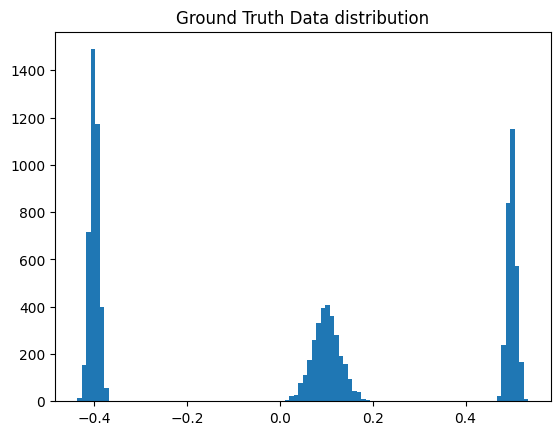

In [51]:
# Data distribution is 30% N(0.5, 0.0001), 30% N(0, 0.0009), 40% N(-0.4, 0.0001)
data  = torch.cat([
    torch.randn(3000, 1) * 0.01 + 0.5,
    torch.randn(3000, 1) * 0.03 + 0.1,
    torch.randn(4000, 1) * 0.01 - 0.4,
])
plt.hist(data.numpy(), bins=100)
plt.title("Ground Truth Data distribution")

# Create dataset and dataloader
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [4]:
# Define global constants
T = 5            # The maximum time, which is equal to the maximum noise standard deviation

EPSILON = 0.002  # The minimum time

In [5]:
class Denoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        "x: shape (batch, 1) t: shape (batch,); return shape (batch, 1)"
        inputs = torch.cat([x, t.unsqueeze(-1)], dim=-1)
        outputs = self.mlp(inputs)
        return outputs

# The score function is derived from the denoiser
def score_function(denoiser, x, t):
    return (denoiser(x, t) - x) / torch.square(t).unsqueeze(-1)

class ConsistencyFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        "x: shape (batch, 1) t: shape (batch,); return shape (batch, 1)"
        inputs = torch.cat([x, t.unsqueeze(-1)], dim=-1)
        outputs = self.mlp(inputs)
        return ((T - t) / (T - EPSILON)).unsqueeze(-1) * x + ((t - EPSILON) / (T - EPSILON)).unsqueeze(-1) * outputs


In [39]:
# Score function (Denoiser actually...) training
denoiser = Denoiser()
denoiser_optimizer = torch.optim.Adam(denoiser.parameters(), lr=1e-3)
denoiser.train()

# Discretize time steps. From EDM Karras et al. It is dense in the beginning and sparse in the end
n_steps_straining = 1000
t_steps = [(EPSILON ** (1 / 7) + (i / (n_steps_straining - 1)) * (T ** (1 / 7) - EPSILON ** (1 / 7))) ** 7 for i in range(0, n_steps_straining)]

N_EPOCHS = 100

with trange(N_EPOCHS) as pbar:
    for epoch in range(N_EPOCHS):
        tot_loss = 0.0
        for x, in dataloader:
            batch_size = x.shape[0]
            
            # Sample time
            t = torch.tensor(random.choices(t_steps, k=batch_size))
            
            # Sample random Gaussian noise
            z = torch.randn(batch_size, 1)

            # Compute loss and update score function xt|x ~ N(xt; x, t^2 I)
            loss = F.mse_loss(denoiser(x + t.unsqueeze(-1) * z, t), x)
            
            loss.backward()
            denoiser_optimizer.step()
            denoiser_optimizer.zero_grad()

            tot_loss += loss.item()
        pbar.set_postfix(loss=tot_loss / len(dataloader))
        pbar.update()


100%|██████████| 100/100 [00:19<00:00,  5.16it/s, loss=0.0639]


In [7]:
@torch.no_grad()
def deterministic_sampling(xT: torch.Tensor, n_steps: int):
    "Deterministic sampling using Heun's 2nd order method"
    t_steps = [(EPSILON ** (1 / 7) + (j / (n_steps - 1)) * (T ** (1 / 7) - EPSILON ** (1 / 7))) ** 7 for j in range(n_steps - 1, 0, -1)]
    batch_size = xT.shape[0]
    xi = xT
    trajectory = [xT]
    for i in range(0, len(t_steps) - 1):
        d = -t_steps[i] * score_function(denoiser, xi, torch.ones(batch_size) * t_steps[i])
        xi_1 = xi + (t_steps[i + 1] - t_steps[i]) * d
        d_ = -t_steps[i + 1] * score_function(denoiser, xi_1, torch.ones(batch_size) * t_steps[i + 1])
        xi_1 = xi + (t_steps[i + 1] - t_steps[i]) / 2 * (d + d_)

        xi = xi_1
        trajectory.append(xi)
        
    return xi, (t_steps, trajectory)

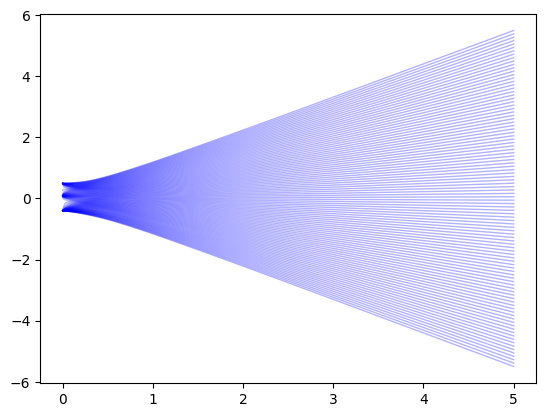

In [8]:
# Visualize Probability Flow ODE dx/dt = -t * score_function(x, t)
n_plot_trajs = 100
x = torch.linspace(-T - 0.5, T + 0.5, n_plot_trajs).unsqueeze(-1)

_, (t_steps, trajectory) = deterministic_sampling(x, 100)

trajectory = torch.cat(trajectory, dim=1).numpy()
for i in range(n_plot_trajs):
    plt.plot(t_steps, trajectory[i, :], color="blue", alpha=0.3, linewidth=1)

Text(0.5, 1.0, 'Deterministic Sampler Generated distribution')

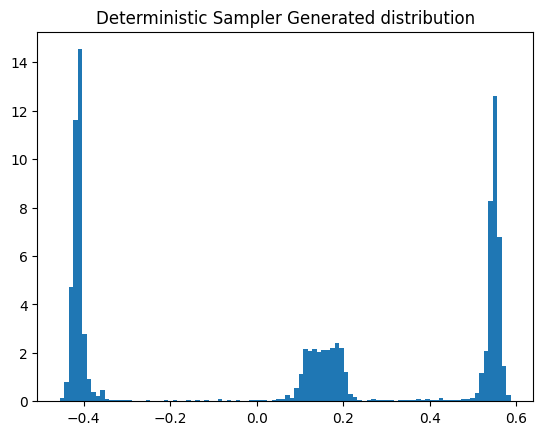

In [52]:
# Visualize the generated distribution
n_samples = 10000
xT = torch.randn(n_samples, 1) * T
x, _ = deterministic_sampling(xT, 10)   # When sampling, we generally use a smaller number of steps
plt.hist(x.numpy()[:, 0], bins=100, density=True)
plt.title("Deterministic Sampler Generated distribution")

In [48]:
# Consistency Distillation
cd = ConsistencyFunction()
cd_optimizer = torch.optim.Adam(cd.parameters(), lr=1e-3)

N_EPOCHS = 200  # Number of epochs

cd_ema = deepcopy(cd)
params_ema = cd_ema.state_dict()

n_steps = 10

with trange(N_EPOCHS) as pbar:
    for epoch in range(N_EPOCHS):
        tot_loss = 0.0
        t_steps = [(EPSILON ** (1 / 7) + (j / (n_steps - 1)) * (T ** (1 / 7) - EPSILON ** (1 / 7))) ** 7 for j in range(0, n_steps)]

        for x, in dataloader:
            batch_size = x.shape[0]
            
            # Sample x_{t_{n+1}}
            n_1 = [random.randint(1, n_steps - 1) for _ in range(batch_size)]
            tn_1 = torch.tensor([t_steps[i] for i in n_1])
            x_tn_1 = x + tn_1.unsqueeze(-1) * torch.randn(batch_size, 1)
            
            # Estimate x_{t_n} by Heun's method
            tn = torch.tensor([t_steps[i - 1] for i in n_1])
            with torch.no_grad():
                d =  -tn_1.unsqueeze(-1) * score_function(denoiser, x_tn_1, tn_1)
                x_tn = x_tn_1 + (tn - tn_1).unsqueeze(-1) * d
                d_ = -tn.unsqueeze(-1) * score_function(denoiser, x_tn, tn)
                x_tn = x_tn_1 + (tn - tn_1).unsqueeze(-1) / 2 * (d + d_)
                
            # Compute loss and update consistency function
            with torch.no_grad():
                out_tn = cd_ema(x_tn, tn)     
            loss = F.mse_loss(cd(x_tn_1, tn_1), out_tn)
            
            loss.backward()
            cd_optimizer.step()
            cd_optimizer.zero_grad()

            params_ema = {k: 0.98 * params_ema[k] + 0.02 * v for k, v in cd.state_dict().items()}
            cd_ema.load_state_dict(params_ema)
            
            tot_loss += loss.item()
        pbar.set_postfix(loss=tot_loss / len(dataloader))
        pbar.update()

100%|██████████| 200/200 [01:11<00:00,  2.81it/s, loss=0.000845]


Text(0.5, 1.0, 'Generated distribution of Consistency Distillation')

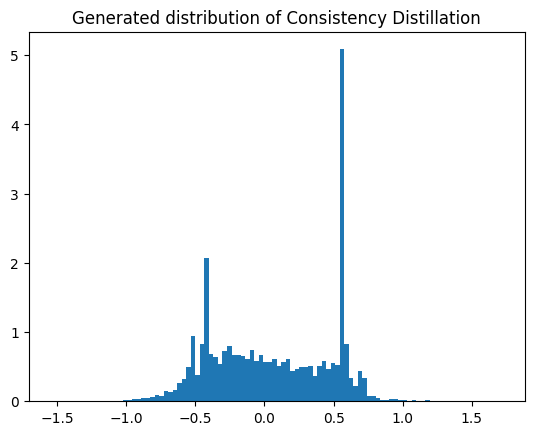

In [50]:
# Visualize the generated distribution of consistency_distillation
n_samples = 10000
xT = torch.randn(n_samples, 1) * T
with torch.no_grad():
    x = cd(xT, torch.ones(n_samples) * T)
plt.hist(x.numpy()[:, 0], bins=100, density=True)
plt.title("Generated distribution of Consistency Distillation")

In [46]:
# Consistency Training
ct = ConsistencyFunction()
ct_optimizer = torch.optim.Adam(ct.parameters(), lr=1e-3)

N_EPOCHS = 400  # Number of epochs

ct_ema = deepcopy(ct)
params_ema = ct_ema.state_dict()

with trange(N_EPOCHS) as pbar:
    for epoch in range(N_EPOCHS):
        tot_loss = 0.0
        n_steps = int(10 + 100 * epoch / N_EPOCHS)
        t_steps = [(EPSILON ** (1 / 7) + (j / (n_steps - 1)) * (T ** (1 / 7) - EPSILON ** (1 / 7))) ** 7 for j in range(0, n_steps)]
    
        for x, in dataloader:
            batch_size = x.shape[0]
            
            # Sample x_{t_{n+1}} = x + t_{n+1} * z, x_{t_n} = x_{t_{n+1}} + (t_n - t_{n+1}) * z = x + t_n * z
            n_1 = [random.randint(1, n_steps - 1) for _ in range(batch_size)]
            tn_1 = torch.tensor([t_steps[i] for i in n_1])
            tn = torch.tensor([t_steps[i - 1] for i in n_1])

            z = torch.randn(batch_size, 1)
            x_tn_1 = x + tn_1.unsqueeze(-1) * z
            x_tn = x + tn.unsqueeze(-1) * z
                
            # Compute loss and update consistency function
            with torch.no_grad():
                out_tn = ct_ema(x_tn, tn)     
                    
            loss = F.mse_loss(ct(x_tn_1, tn_1), out_tn)
            
            loss.backward()
            ct_optimizer.step()
            ct_optimizer.zero_grad()

            params_ema = {k: 0.98 * params_ema[k] + 0.02 * v for k, v in ct.state_dict().items()}
            ct_ema.load_state_dict(params_ema)

            tot_loss += loss.item()
        pbar.set_postfix(loss=tot_loss / len(dataloader))
        pbar.update()

100%|██████████| 400/400 [01:57<00:00,  3.40it/s, loss=0.000221]


Text(0.5, 1.0, 'Generated distribution of Consistency Training')

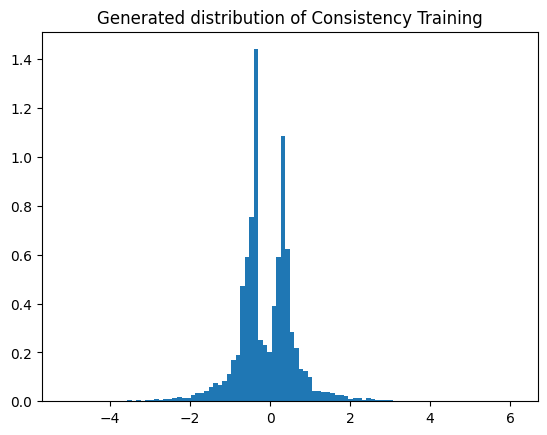

In [47]:
# Visualize the generated distribution of consistency_training
n_samples = 10000
xT = torch.randn(n_samples, 1) * T
with torch.no_grad():
    x = ct(xT, torch.ones(n_samples) * T)
plt.hist(x.numpy()[:, 0], bins=100, density=True)
plt.title("Generated distribution of Consistency Training")